In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/face-recognition/Dataset/Alvi/208.jpg
/kaggle/input/face-recognition/Dataset/Alvi/473.jpg
/kaggle/input/face-recognition/Dataset/Alvi/333.jpg
/kaggle/input/face-recognition/Dataset/Alvi/537.jpg
/kaggle/input/face-recognition/Dataset/Alvi/45.jpg
/kaggle/input/face-recognition/Dataset/Alvi/369.jpg
/kaggle/input/face-recognition/Dataset/Alvi/56.jpg
/kaggle/input/face-recognition/Dataset/Alvi/89.jpg
/kaggle/input/face-recognition/Dataset/Alvi/20.jpg
/kaggle/input/face-recognition/Dataset/Alvi/275.jpg
/kaggle/input/face-recognition/Dataset/Alvi/212.jpg
/kaggle/input/face-recognition/Dataset/Alvi/239.jpg
/kaggle/input/face-recognition/Dataset/Alvi/58.jpg
/kaggle/input/face-recognition/Dataset/Alvi/150.jpg
/kaggle/input/face-recognition/Dataset/Alvi/6.jpg
/kaggle/input/face-recognition/Dataset/Alvi/109.jpg
/kaggle/input/face-recognition/Dataset/Alvi/149.jpg
/kaggle/input/face-recognition/Dataset/Alvi/187.jpg
/kaggle/input/face-recognition/Dataset/Alvi/521.jpg
/kaggle/input/face-

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input
import cv2
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
from tensorflow.keras.applications import ResNet50

In [5]:
# Path to the dataset
data_path = '/kaggle/input/face-recognition/Dataset'

# List the categories (folders) in the data path
categories = [folder for folder in os.listdir(data_path) if folder != "img"]
print(categories)

['Alvi', 'Sanjid', 'Rifat', 'Faisal', 'Asif']


In [6]:
#Prepare the training data
train_data = []

# Limit the number of images per class
max_images_per_class = 1000

for c in categories:
    path = os.path.join(data_path, c)
    class_index = categories.index(c)
    count = 0  # Counter for the current class
    
    for img in tqdm(os.listdir(path)):
        if count >= max_images_per_class:  # Stop after max_images_per_class images
            break
        
        try:
            # Read the image in grayscale
            img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            # Normalize and resize the image
            img_arr = img_arr / 255.0  # Normalize to range [0, 1]
            img_arr = cv2.resize(img_arr, (256, 256))
            # Convert grayscale to RGB by stacking
            img_arr_rgb = np.stack((img_arr, img_arr, img_arr), axis=-1)
            # Append the image and its class label to the training data
            train_data.append([img_arr_rgb, class_index])
            count += 1  # Increment the counter
        except Exception as e:
            print(f"Error processing image {img}: {e}")

print(f"Total training samples: {len(train_data)}")


100%|██████████| 550/550 [00:05<00:00, 103.18it/s]

Total training samples: 2687


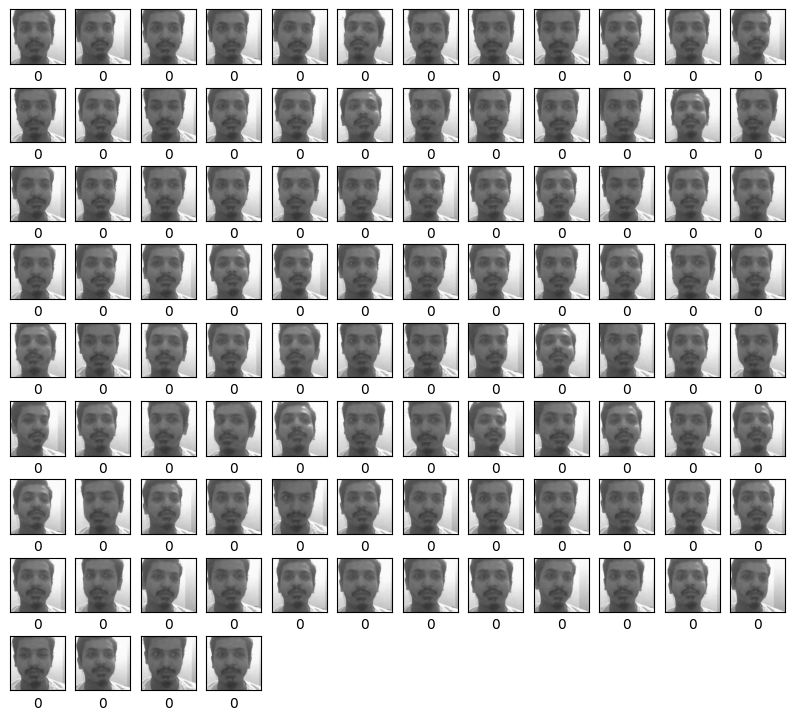

In [7]:
# Plot a subset of images
plt.figure(figsize=(10,10))
i = 0
for r in range(10):
    for c in range(10):
        plt.subplot(10, 12, i + 1)
        plt.imshow(train_data[i][0], cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.xlabel(train_data[i][1])
        i += 1
plt.show()

In [8]:
# Prepare the data for training
np.random.shuffle(train_data)
X, y = zip(*train_data)
X = np.array(X, dtype=np.float32) / 255.0  # Normalize the images
y = np.array(y)

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training data shape: {X_train.shape}, Validation data shape: {X_val.shape}")

# One-hot encode the labels for multi-class classification
y_train = to_categorical(y_train, num_classes=5)
y_val = to_categorical(y_val, num_classes=5)

Training data shape: (2149, 256, 256, 3), Validation data shape: (538, 256, 256, 3)


In [10]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
 
# Define input shape
input_shape = (256, 256, 3)
 
# Path to the uploaded weights in Kaggle
weights_path = "/kaggle/input/resnet50-weights-tf-dim-ordering-tf-kernels-notop/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
 
# Load ResNet50 with manually uploaded weights
base_model = ResNet50(weights=weights_path, include_top=False, input_tensor=Input(shape=input_shape))
 
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False
 
# Add custom layers for classification
x = Flatten()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(5, activation='softmax')(x)  # 5 classes, softmax activation
 
# Define the final model
model = Model(inputs=base_model.input, outputs=output)
 
# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 158,520,581 (604.71 MB)

 Trainable params: 134,932,869 (514.73 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [11]:

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [13]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=16,
    batch_size=60,
)

Epoch 1/16
36/36 ━━━━━━━━━━━━━━━━━━━━ 452s 12s/step - accuracy: 0.1818 - loss: 1.6097 - val_accuracy: 0.1970 - val_loss: 1.6106
Epoch 2/16
36/36 ━━━━━━━━━━━━━━━━━━━━ 424s 12s/step - accuracy: 0.2021 - loss: 1.6100 - val_accuracy: 0.1970 - val_loss: 1.6103
Epoch 3/16
36/36 ━━━━━━━━━━━━━━━━━━━━ 429s 12s/step - accuracy: 0.2054 - loss: 1.6097 - val_accuracy: 0.1970 - val_loss: 1.6099
Epoch 4/16
36/36 ━━━━━━━━━━━━━━━━━━━━ 435s 12s/step - accuracy: 0.2168 - loss: 1.6093 - val_accuracy: 0.1970 - val_loss: 1.6096
Epoch 5/16
36/36 ━━━━━━━━━━━━━━━━━━━━ 419s 11s/step - accuracy: 0.2040 - loss: 1.6091 - val_accuracy: 0.1896 - val_loss: 1.6092
Epoch 6/16
36/36 ━━━━━━━━━━━━━━━━━━━━ 440s 12s/step - accuracy: 0.1807 - loss: 1.6095 - val_accuracy: 0.1896 - val_loss: 1.6092
Epoch 7/16
36/36 ━━━━━━━━━━━━━━━━━━━━ 449s 12s/step - accuracy: 0.2076 - loss: 1.6086 - val_accuracy: 0.1896 - val_loss: 1.6087
Epoch 8/16
36/36 ━━━━━━━━━━━━━━━━━━━━ 432s 12s/step - accuracy: 0.2000 - loss: 1.6089 - val_accuracy: 0.

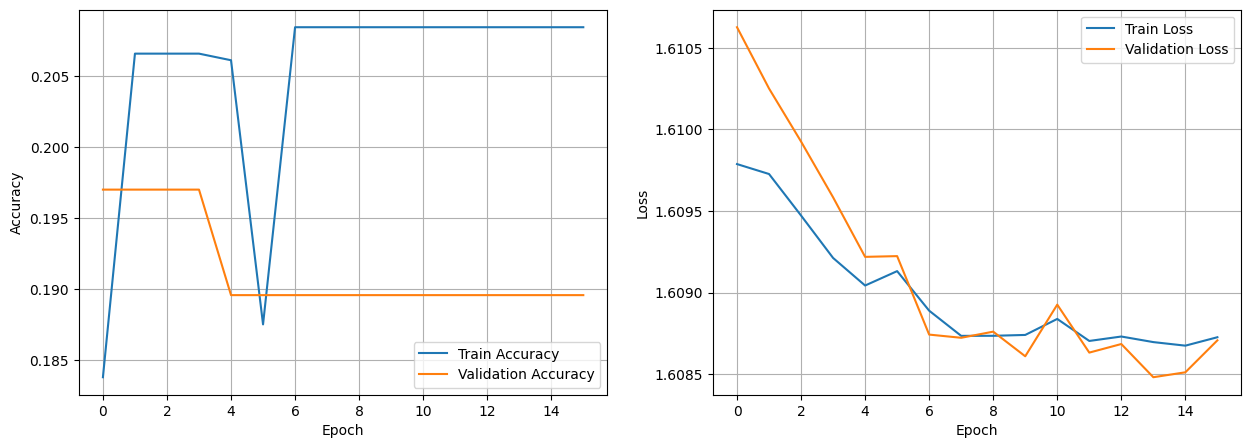

In [14]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()